In [1]:
import uproot
import os
import mplhep as hep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from importer import get_closest_muon_data, verify_events, apply_genmatching
from plotting import histogram, q_comparison
from helper import initialize_dir
plt.style.use(hep.style.CMS)


In [ ]:

hdf_path = "../data/converted/converted_nanoaod.h5"

data_df = pd.read_hdf(hdf_path, "data_df")
emb_df = pd.read_hdf(hdf_path, "emb_df")
matched_emb_df = pd.read_hdf(hdf_path, "emb_df_matched_filtered")

verify_events(data_df, emb_df)

print("Data loaded and verified")


Data loaded and verified


In [3]:
filter_list = [
    {"col":"pt", "min":27, "max":np.inf, "emb":True, "data":True},
    {"col":"eta", "min":-2.5, "max":2.5, "emb":True, "data":True},
    {"col":"dr", "min":0, "max":0.001},
    {"col":"pt_ratio", "min":0.75, "max":1.25}
]

In [4]:

def anaylize_mask(mask):
    nan_count = np.isnan(mask).sum()
    print(nan_count)

#following code is for genmatching
def calculate_dr(data_df, emb_df, n_data, n_emb, filter=None):
    #this function returns the dr value for all particle combination from embedding
    #the first "n_data" particles of data are compare to the first "n_emb" particles of the embeddign dataset

    dr_arr = np.full(shape=(len(data_df), n_data, n_emb), dtype=float, fill_value=np.nan)

    #looping over all data particle and embedding particle combinations
    for n_d in range(1, n_data+1):
        for n_e in range(1, n_emb+1):
            eta_diff = data_df[f"eta_{n_d}"] - emb_df[f"eta_{n_e}"]
            phi_diff = data_df[f"phi_{n_d}"] - emb_df[f"phi_{n_e}"]

            #calculating the dr value between them for all events
            dr_temp = np.sqrt(np.square(eta_diff) + np.square(phi_diff))

            if type(filter) != type(None):

                for f in filter:
                    basename = f["col"]
                    min_val = f["min"]
                    max_val = f["max"]
                    
                    if basename != "dr" and basename != "pt_ratio":
                        if f["emb"]:
                            mask1 = emb_df[f"{basename}_{n_e}"] < min_val 
                            mask2 = emb_df[f"{basename}_{n_e}"] > max_val 
                            mask = np.logical_or(mask1, mask2)
                            dr_temp[mask] = np.nan
                        if f["data"]:
                            mask1 = data_df[f"{basename}_{n_d}"] < min_val 
                            mask2 = data_df[f"{basename}_{n_d}"] > max_val 
                            mask = np.logical_or(mask1, mask2)
                            dr_temp[mask] = np.nan
                    elif basename == "dr":
                        mask1 = dr_temp < min_val
                        mask2 = dr_temp > max_val
                        mask = np.logical_or(mask1, mask2)
                        dr_temp[mask] = np.nan
                    elif basename == "pt_ratio":
                        pt_ratio = data_df[f"pt_{n_d}"]/ emb_df[f"pt_{n_e}"]
                        mask1 = pt_ratio < min_val
                        mask2 = pt_ratio > max_val
                        mask = np.logical_or(mask1, mask2)
                        dr_temp[mask] = np.nan
            dr_arr[:, n_d-1, n_e-1] = dr_temp

    return dr_arr

In [5]:
def find_closest_muon(dr_slice):
    nan_mask = ~np.isnan(dr_slice)

    if nan_mask.sum() > 0:
        index = np.nanargmin(dr_slice)
        return index
    return np.nan
        

def remove_emb_mu_from_dist(dist, id):
    # print(id)
    if ~np.isnan(id):
        dist[:, id] = np.nan
    return dist

def apply_genmatching(dr_arr, df, switch_quantities):

    for n_event in range(len(df)):
        distances = dr_arr[n_event, :, :]
        
        muon1_id = find_closest_muon(distances[0, :])
        distances = remove_emb_mu_from_dist(distances, muon1_id)

        muon2_id = find_closest_muon(distances[1, :])
        
        #ignoring nans
        if np.isnan([muon1_id, muon2_id]).sum() == 0:
            #nothing to change if best fit is trivial
            if muon1_id != 0 and muon2_id != 1:
                for q_name in switch_quantities:
                    #check whether quantity should be updated
                    temp1 = df.loc[n_event, f"{q_name}_{muon1_id+1}"]
                    temp2 = df.loc[n_event, f"{q_name}_{muon2_id+1}"]
                    #updating quantity
                    df.loc[n_event, f"{q_name}_1"] = temp1
                    df.loc[n_event, f"{q_name}_2"] = temp2
    
    return df

In [6]:
#dr between data and embedding without matching 
dr_raw = calculate_dr(data_df, emb_df, 2, 5, filter=None)
emb_matched = apply_genmatching(dr_raw.copy(), emb_df.copy(deep=True), ["phi", "pt", "eta", "m"])

In [12]:
test = emb_df["phi_1"] - emb_matched["phi_1"]
test[test!=0]

34      -3.175064
64       3.385956
78       3.111137
99       3.484787
108     -3.738174
           ...   
24895    3.400787
24906   -3.676285
24915   -3.214386
24935   -2.917038
24943   -2.798832
Name: phi_1, Length: 2106, dtype: float32

In [69]:
#dr between data and embedding without matching 
dr_raw = calculate_dr(data_df, emb_df, 2, 5, filter=None)
emb_no_filter = apply_genmatching(dr_raw.copy(), emb_df.copy(deep=True), ["phi", "pt", "eta", "m"])
dr_no_filter = calculate_dr(data_df, emb_no_filter, 2, 5, filter=filter_list)

dr_raw_filter = calculate_dr(data_df, emb_df, 2, 5, filter=filter_list)
emb_filter = apply_genmatching(dr_raw_filter.copy(), emb_df.copy(deep=True), ["phi", "pt", "eta", "m"])
dr_filter = calculate_dr(data_df, emb_filter, 2, 5, filter=None)

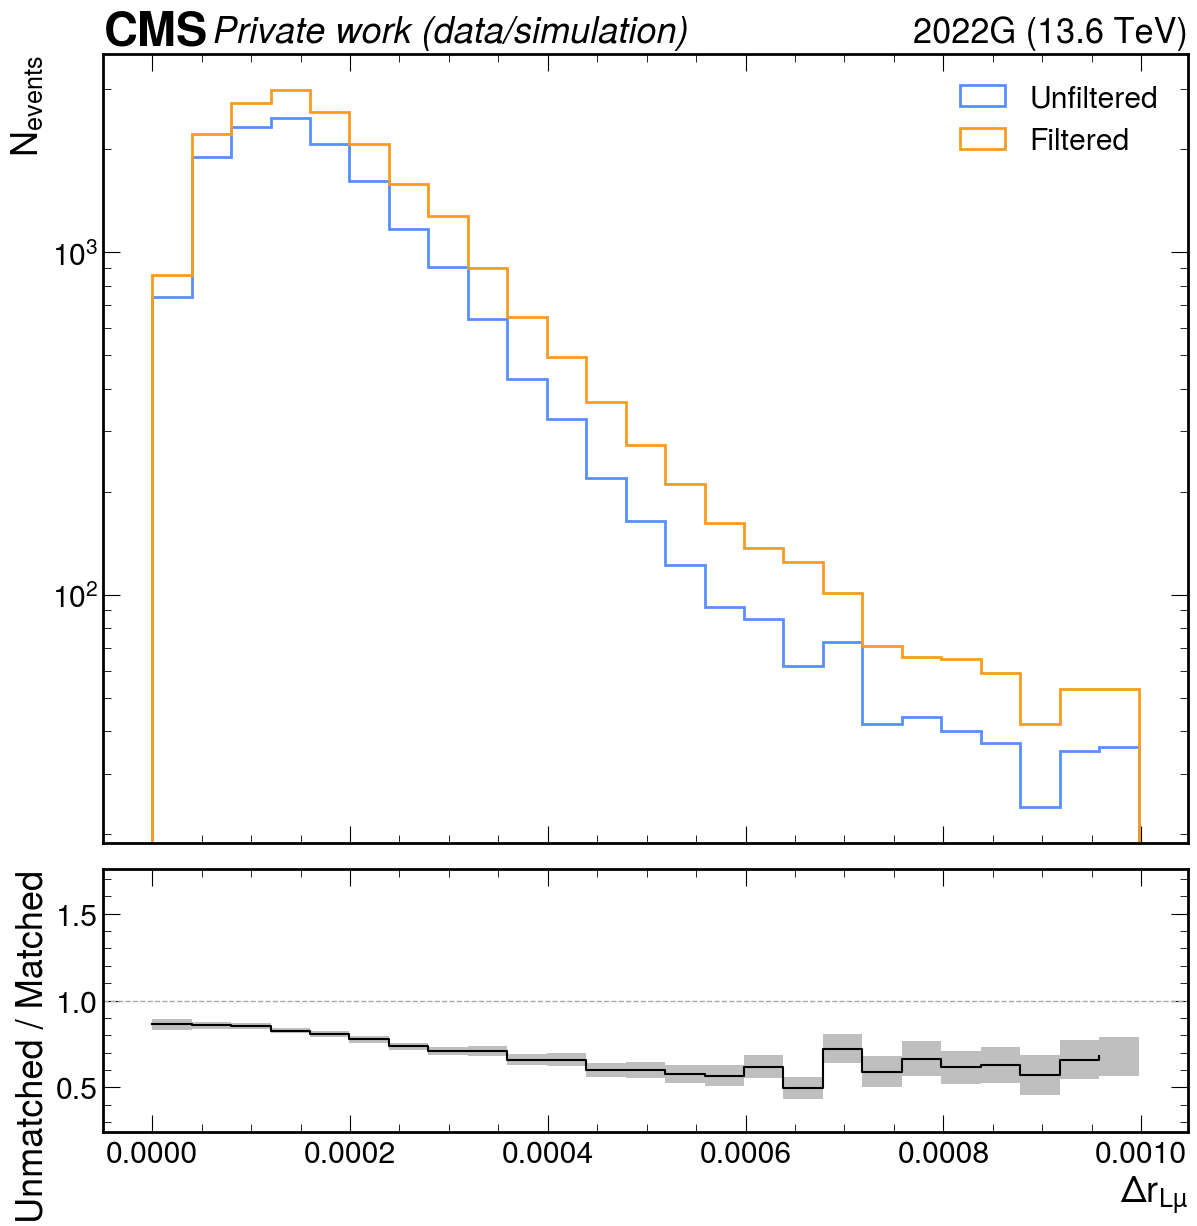

In [70]:
ax = q_comparison(dr_no_filter[:,0,0], dr_filter[:,0,0], 25, "Unfiltered", "Filtered", r"$\Delta r_\text{Lµ}$")

plt.show()

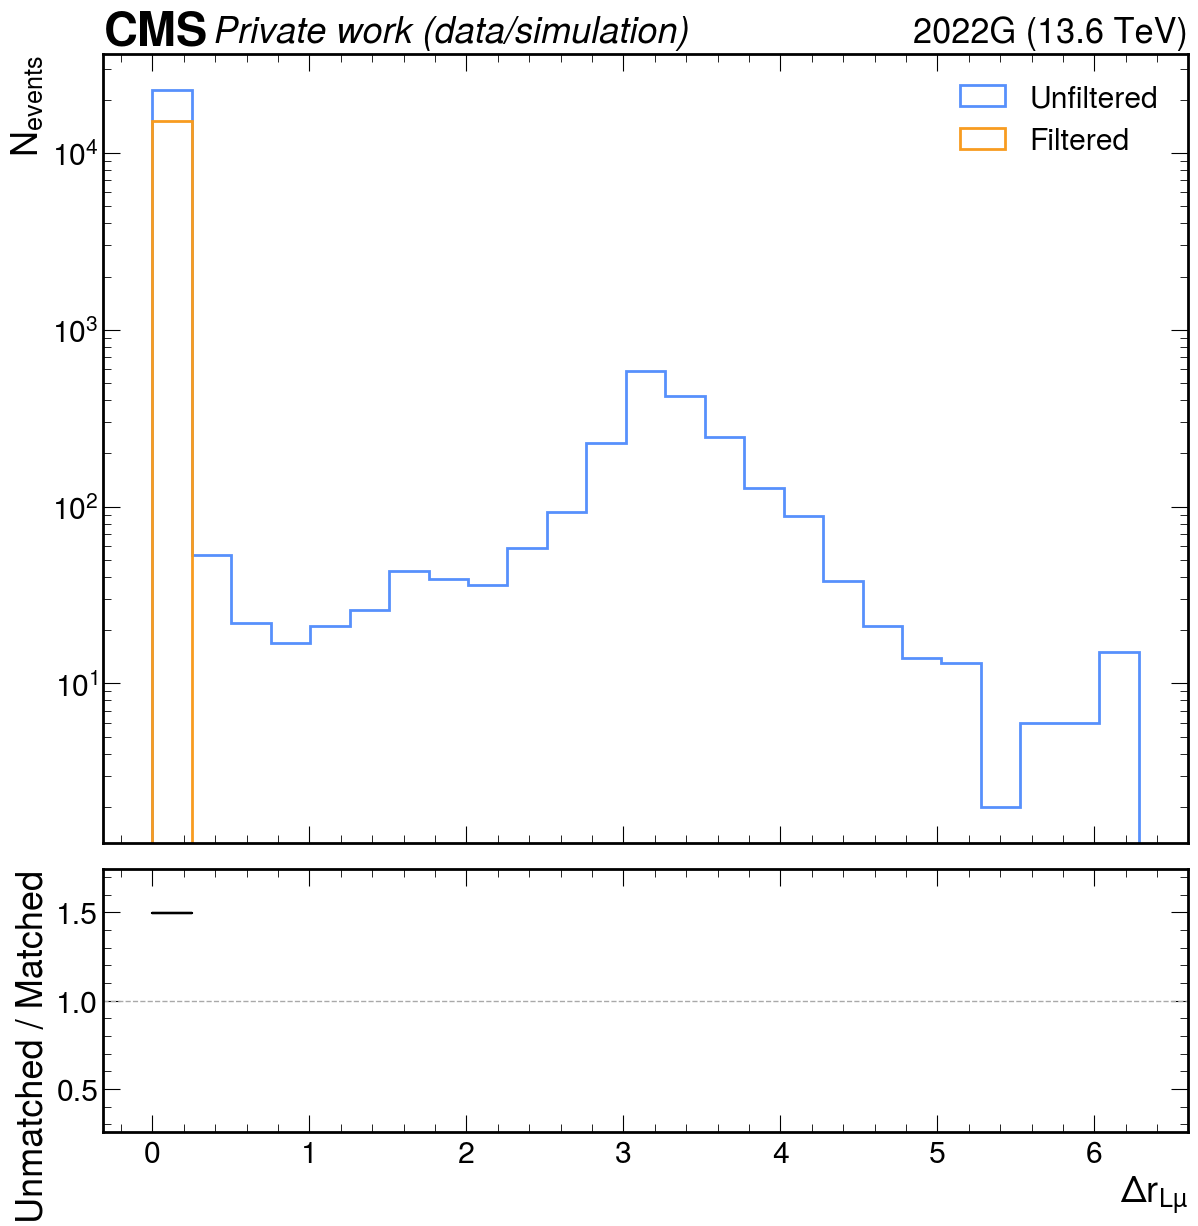

In [71]:
ax = q_comparison(dr_raw[:,0,0], dr_raw_filter[:,0,0], 25, "Unfiltered", "Filtered", r"$\Delta r_\text{Lµ}$")

plt.show()